In [294]:
import numpy as np
import pandas as pd
import smogn
import seaborn
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, chi2
from tsfresh.transformers import FeatureSelector
np.random.seed(8055)

In [310]:
# Loading and processing data
nomed = True
nolab = True
noinfusion = True

discard_dead = True
only_dead = True

data = pd.read_csv('los_surv_analysis_dat.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

labs_tokeep = ['LAB_Hgb', 'LAB_Hct', 'LAB_glucose', 'LAB_platelets x 1000', 'LAB_WBC x 1000']


if (nomed):
    data = data[data.columns.drop(list(data.filter(regex='MED_')))]
if (nolab):
    data = data[data.columns.drop([i for i in list(data.filter(regex='LAB_')) if i not in labs_tokeep])]
if (noinfusion):
    data = data[data.columns.drop(list(data.filter(regex='INF_')))]

if (discard_dead):
    # Drop patients who died
    data = data[data['death'] == False]
elif (only_dead):
    # Drop patients who survived
    data = data[data['death'] == True]

# Drop patients with los > 30
data = data[data['los'] <= 30]

los = list(data['los'])

cols_todrop = ['patientunitstayid', 'death', 'Value', 'GCS', 'occurs', 'los']
data = data.drop(columns=cols_todrop)

display(data)

,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure Support,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal
1,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104413,1.484555,3.001141,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
2,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791429,-10.294405,-9.548990,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
3,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.533416,31.960579,-14.284973,17.194001,-9.265372,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0
4,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-59.499693,2.779041,31.849160,0.576734,4.749407,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1.0
5,-3.097281,0.190085,-0.071351,-0.041548,0.014309,167.009674,30.042029,-2.141961,4.078316,-6.651608,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-11.479460,-13.717313,24.588927,9.666096,-4.025659,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1685,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-126.098771,-7.008613,2.239281,-5.131776,0.876373,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1686,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-75.196338,12.732793,11.465426,5.491674,-4.167290,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1687,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.151090,3.753644,38.058612,-5.158480,2.491408,...,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0


# Resampling (Trying smoteR but doesn't seem to work)
## https://www.kaggle.com/aleksandradeis/regression-addressing-extreme-rare-cases

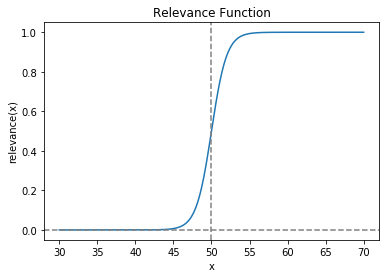

In [23]:
def sigmoid(x):
    return np.exp(x)/(np.exp(x) + 1)

# implement relevance function
# see paper: https://www.researchgate.net/publication/220699419_Utility-Based_Regression
def relevance(x):
    x = np.array(x)
    return sigmoid(x - 50)

# plot relevance function
plt.plot(np.linspace(30, 70, 1000), relevance(np.linspace(30, 70, 1000)))
plt.title('Relevance Function')
plt.xlabel('x')
plt.axhline(y=0, c='gray', linestyle='--')
plt.axvline(x=50, c='gray', linestyle='--')
plt.ylabel('relevance(x)')
plt.show()

In [24]:
# implement SMOTER
# see paper: https://core.ac.uk/download/pdf/29202178.pdf

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = o // 100 # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}                      
            for a in D.columns:
                # skip target column
                if a == target:
                    continue;
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            new_cases = new_cases.append(attr,ignore_index = True)
                    
    return new_cases


def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
       
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal,los
0,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565423,14.478607,6.298129,9.661274,...,0.0,1.0,1.0,1.0,1,0,1,1,0.0,6.9319
1,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104413,1.484555,3.001141,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.8625
2,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791429,-10.294405,-9.548990,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,10.0014
3,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.533416,31.960579,-14.284973,17.194001,-9.265372,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,6.5340
4,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-59.499693,2.779041,31.849160,0.576734,4.749407,...,0.0,0.0,0.0,0.0,0,0,0,0,1.0,2.5028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-11.479460,-13.717313,24.588927,9.666096,-4.025659,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.0063
1685,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-126.098771,-7.008613,2.239281,-5.131776,0.876373,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,8.2465
1686,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-75.196338,12.732793,11.465426,5.491674,-4.167290,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,7.6736
1687,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.151090,3.753644,38.058612,-5.158480,2.491408,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,14.9396


,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal,los
1155,1.801272,0.206165,-0.029003,-0.059649,-0.014008,0.708365,52.845515,-25.277815,-22.516681,-24.236495,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,13.9528
349,12.412750,7.010158,-2.796162,-0.456212,-1.869884,-46.267098,3.329730,2.127164,-0.061251,-0.231034,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,17.8854
725,1.395075,0.955656,-0.714954,-0.710800,0.305143,-84.725346,11.840455,-14.248661,-5.307077,-5.302078,...,0.0,1.0,0.0,0.0,0,0,0,0,0.0,7.8188
0,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565423,14.478607,6.298129,9.661274,...,0.0,1.0,1.0,1.0,1,0,1,1,0.0,6.9319
965,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-33.945374,-6.543025,24.146404,-8.356944,-14.595857,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,14.9125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-22.387596,-16.090876,1.132715,23.531955,-8.067481,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,9.2222
22,2.007534,0.145578,-0.307546,-0.083623,-0.258509,182.657615,-19.477419,8.993750,-7.063105,2.716172,...,0.0,1.0,1.0,1.0,0,0,0,1,0.0,21.6590
460,8.159069,-2.675643,-1.947723,0.827494,0.056375,-7.536066,-44.000520,-1.345284,1.687464,-8.383321,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,2.1625
1210,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-2.449106,29.464839,-10.881949,-0.991617,5.451761,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.7736


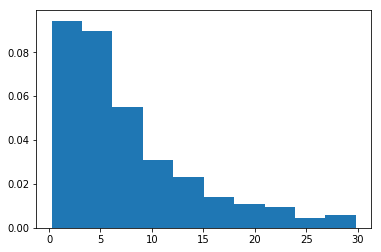

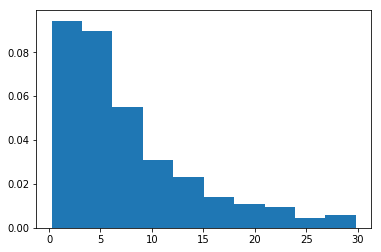

In [59]:
categorical_columns = data.columns[data.columns != 'los']
new = SmoteR(data, target='los', th = 1, o = 1000, u = 1000, k = 10, categorical_col=categorical_columns)

num_bins = 10

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(los, num_bins, density=1)

num_bins = 10

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(list(new['los']), num_bins, density=1)


# Resampling: SMOGN (doesn't work :'))
## https://pypi.org/project/smogn/#:~:text=Description,Noise%20(SMOTER%2DGN).

In [122]:
display(data)

,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal,los
0,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565423,14.478607,6.298129,9.661274,...,0.0,1.0,1.0,1.0,1,0,1,1,0.0,6.9319
1,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104413,1.484555,3.001141,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.8625
2,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791429,-10.294405,-9.548990,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,10.0014
3,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.533416,31.960579,-14.284973,17.194001,-9.265372,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,6.5340
4,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-59.499693,2.779041,31.849160,0.576734,4.749407,...,0.0,0.0,0.0,0.0,0,0,0,0,1.0,2.5028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-11.479460,-13.717313,24.588927,9.666096,-4.025659,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.0063
1685,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-126.098771,-7.008613,2.239281,-5.131776,0.876373,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,8.2465
1686,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-75.196338,12.732793,11.465426,5.491674,-4.167290,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,7.6736
1687,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.151090,3.753644,38.058612,-5.158480,2.491408,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,14.9396


In [373]:
# ## conduct smogn
# data_smogn = smogn.smoter(
    
#     data = data,  ## pandas dataframe
#     y = 'los',  ## string ('header name')
#     drop_na_col=False
# )

# Modeling

# XGBoost

In [311]:
# Binning
bins = [int(i) for i in np.linspace(0, 30, 5)]
print(bins)
y_binned = np.digitize(los, bins)
X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2, random_state=123)
display(X_train)

[0, 7, 15, 22, 30]


,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure Support,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal
57,3.441729,-1.921219,-0.028609,-0.637959,-0.080542,117.504744,28.312452,21.856256,-12.082505,-1.878385,...,0.0,0.0,1.0,1.0,1.0,1,0,0,1,0.0
624,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-34.055357,-10.542777,-7.540850,7.063390,-2.408572,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
725,1.395075,0.955656,-0.714954,-0.710800,0.305143,-84.725346,11.840455,-14.248661,-5.307077,-5.302078,...,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0.0
1043,-3.097281,0.190085,-0.071351,-0.041548,0.014309,13.789420,-9.792780,32.096632,15.303866,-6.309704,...,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0.0
1460,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-117.831124,14.777126,-15.872735,-12.944562,11.780405,...,1.0,0.0,1.0,1.0,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-13.946772,-12.689590,21.689179,-2.006573,0.970646,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
863,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-88.074965,17.695391,0.179136,0.956765,-6.086540,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1041,-3.097281,0.190085,-0.071351,-0.041548,0.014309,57.010571,-32.505122,-18.428726,5.408216,0.034643,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1151,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-63.848240,0.302315,1.695757,-7.829465,-1.050974,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0


In [312]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 100, n_estimators = 10)

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)
xg_reg.fit(X_train_norm,y_train)

preds = xg_reg.predict(X_test_norm)

In [313]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 6.131991


In [314]:
# Cross Validation
data_dmatrix = xgb.DMatrix(data=preprocessing.normalize(data),label=los)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 2, 'alpha': 100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

display(cv_results)
print((cv_results["test-rmse-mean"]).tail(1))

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.146625,0.032829,9.157231,0.070790
1,8.635611,0.026199,8.652604,0.074713
2,8.181091,0.026625,8.216757,0.069899
3,7.802389,0.029470,7.854416,0.069472
4,7.472441,0.025595,7.537026,0.074743
5,7.181234,0.026870,7.261351,0.082199
6,6.934563,0.018097,7.025573,0.087069
7,6.708290,0.028502,6.820441,0.085572
8,6.514327,0.028872,6.636184,0.096423
9,6.339838,0.027082,6.485397,0.112392


49    5.430832
Name: test-rmse-mean, dtype: float64


7.8477076976906925
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
<= 0 < 1: 54
<= 1 < 2: 128
<= 2 < 3: 145
<= 3 < 4: 161
<= 4 < 5: 140
<= 5 < 6: 110
<= 6 < 7: 103
<= 7 < 8: 86
<= 8 < 9: 66
<= 9 < 10: 56
<= 10 < 11: 51
<= 11 < 12: 29
<= 12 < 13: 39
<= 13 < 14: 36
<= 14 < 15: 25
<= 15 < 16: 25
<= 16 < 17: 22
<= 17 < 18: 16
<= 18 < 19: 14
<= 19 < 20: 24
<= 20 < 21: 16
<= 21 < 22: 13
<= 22 < 23: 16
<= 23 < 24: 9
<= 24 < 25: 4
<= 25 < 26: 9
<= 26 < 27: 8
<= 27 < 28: 7
<= 28 < 29: 9
<= 29 < 30: 8
<= 30 < 31: 0


Text(0, 0.5, 'Frequency')

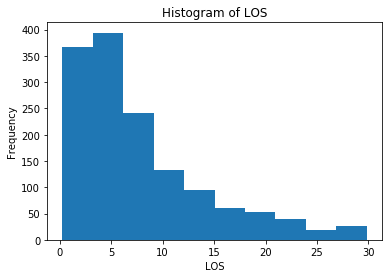

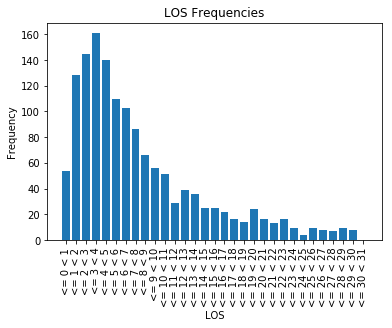

In [323]:
# Plotting a histogram of LOS
print(np.mean(los))
plt.figure()
plt.hist(los)
plt.title('Histogram of LOS')
plt.xlabel('LOS')
plt.ylabel('Frequency')

b = [int(i) for i in np.linspace(0,31,32)]
print(b)

freqs =  []
xlabs = []
for i in range(len(b)-1):
    filt = [j for j in los if (j >= b[i] and j < b[i+1])]
    freqs.append(len(filt))
    xlabs.append('<= '+str(b[i])+' < '+str(b[i+1]))
    print('<= '+str(b[i])+' < '+str(b[i+1])+': '+str(len(filt)))

plt.figure()
plt.bar(xlabs, freqs)
plt.xticks(rotation='vertical')
plt.title('LOS Frequencies')
plt.xlabel('LOS')
plt.ylabel('Frequency')

In [327]:
# select features using threshold
numfeat = 40
# for thresh in [0.05, -np.inf]:

n_groups = 3
# groups = [int(i) for i in np.linspace(0, 31, n_groups+1)]

# Recommended by Stevens
groups = [0, 3, 8, math.inf]

# # Trying to get all groups to have roughly the same number of patients
# los_sorted = los.copy()
# los_sorted.sort()
# n_groups = 3
# group_idcs = [int(i) for i in np.linspace(0, len(los_sorted)-1, n_groups+1)]
# groups = [los_sorted[i] for i in group_idcs]


print(groups)

train_rmses = []
test_rmses = []
grouped_train_rmses = [0]*n_groups
grouped_test_rmses = [0]*n_groups
grouped_train_rmses_onval = [0]*n_groups
grouped_test_rmses_onval = [0]*n_groups
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2)
    for thresh in [-np.inf]:
        selection = SelectFromModel(xg_reg, threshold=thresh, prefit=True, max_features=numfeat)
        feature_idx = selection.get_support()
        feature_name = X_train.columns[feature_idx]
#         print(feature_name)
        select_X_train = selection.transform(X_train)
        
        X_train_norm = preprocessing.normalize(select_X_train)

        # train model
        selection_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 2, alpha = 100, n_estimators = 100)
        
        # For dead: use 
        selection_model.fit(X_train_norm,y_train)

        # eval model
        select_X_test = selection.transform(X_test)
        X_test_norm = preprocessing.normalize(select_X_test)
        y_pred = selection_model.predict(X_test_norm)
        y_train_pred = selection_model.predict(X_train_norm)
        
        train_labs = pd.DataFrame(list(zip(y_train_pred, y_train)), columns=['y_pred', 'y_train'])
        for i in range(n_groups):
            df1 = train_labs[train_labs['y_train'] >= groups[i]]
            df1 = df1[df1['y_train'] < groups[i+1]]
            print(df1.shape[0])
            yt = list(df1['y_train'])
            yp = list(df1['y_pred'])
            grouped_train_rmses[i] = grouped_train_rmses[i] + np.sqrt(mean_squared_error(yt, yp))
        
        train_labs = pd.DataFrame(list(zip(y_train_pred, y_train)), columns=['y_pred', 'y_train'])
        for i in range(n_groups):
            df1 = train_labs[train_labs['y_pred'] >= groups[i]]
            df1 = df1[df1['y_pred'] < groups[i+1]]
            yt = list(df1['y_train'])
            yp = list(df1['y_pred'])
            if (df1.shape[0] > 0):
                grouped_train_rmses_onval[i] = grouped_train_rmses_onval[i] + np.sqrt(mean_squared_error(yt, yp))
            else:
                grouped_train_rmses_onval[i] = math.inf

            
        test_labs = pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])
        for i in range(n_groups):
            df1 = test_labs[test_labs['y_test'] >= groups[i]]
            df1 = df1[df1['y_test'] < groups[i+1]]
            yt = list(df1['y_test'])
            yp = list(df1['y_pred'])
            grouped_test_rmses[i] = grouped_test_rmses[i] + np.sqrt(mean_squared_error(yt, yp))
            
        test_labs = pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])
        for i in range(n_groups):
            df1 = test_labs[test_labs['y_pred'] >= groups[i]]
            df1 = df1[df1['y_pred'] < groups[i+1]]
            yt = list(df1['y_test'])
            yp = list(df1['y_pred'])
            if (df1.shape[0] > 0):
                grouped_test_rmses_onval[i] = grouped_test_rmses_onval[i] + np.sqrt(mean_squared_error(yt, yp))
            else:
                grouped_test_rmses_onval[i] = math.inf

        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_rmses.append(train_rmse)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_rmses.append(rmse)
        print("Train RMSE: %f" % (train_rmse))
        print("Test RMSE: %f" % (rmse))

[0.2819, 3.9208, 8.3729, 29.8333]
383
375
385
Train RMSE: 4.726337
Test RMSE: 5.369706
385
374
383
Train RMSE: 4.879548
Test RMSE: 4.816668
384
374
384
Train RMSE: 4.749009
Test RMSE: 5.270695
372
394
376
Train RMSE: 4.713263
Test RMSE: 5.450042
370
392
380
Train RMSE: 4.707603
Test RMSE: 5.329130
386
371
385
Train RMSE: 4.706730
Test RMSE: 5.431231
373
391
378
Train RMSE: 4.757891
Test RMSE: 5.237366
381
374
388
Train RMSE: 4.831043
Test RMSE: 4.961416
376
387
379
Train RMSE: 4.684390
Test RMSE: 5.481795
382
384
376
Train RMSE: 4.732266
Test RMSE: 5.485620
378
381
384
Train RMSE: 4.813260
Test RMSE: 5.137034
382
378
382
Train RMSE: 4.774854
Test RMSE: 5.162326
382
383
377
Train RMSE: 4.707821
Test RMSE: 5.464728
390
375
378
Train RMSE: 4.692035
Test RMSE: 5.379371
385
375
382
Train RMSE: 4.706093
Test RMSE: 5.485649
373
389
380
Train RMSE: 4.763937
Test RMSE: 5.175392
375
387
381
Train RMSE: 4.753818
Test RMSE: 5.310925
369
390
383
Train RMSE: 4.728008
Test RMSE: 5.273232
375
391
376


In [322]:
print(np.mean(train_rmses))
print(np.mean(test_rmses))

print()

print([i/20 for i in grouped_train_rmses])
print([i/20 for i in grouped_test_rmses])

print()

print([i/20 for i in grouped_train_rmses_onval])
print([i/20 for i in grouped_test_rmses_onval])

4.757758533719768
5.246631319868131

[4.101107424540388, 2.863948690450031, 6.6143575517614766]
[4.5900562800345295, 3.1215635959644716, 7.240589645205141]

[1.1990289452225158, 3.71724735773182, 6.103363243437783]
[inf, 4.154222291868936, 6.624809070618279]


In [318]:
for f in feature_name:
    print(f)

gcs0
gcs1
gcs2
gcs3
gcs4
hr0
hr1
hr2
hr3
hr4
resp0
resp1
resp2
resp3
resp4
sao20
sao21
sao22
sao23
sao24
NC_verbal
NC_eyes
NC_temp
LAB_Hct
LAB_Hgb
LAB_WBC x 1000
LAB_glucose
LAB_platelets x 1000
DEM_age
DEM_admissionheight
DEM_admissionweight
DEM_gender
AP_sys
AP_dias
AP_bp
RESP_PEEP
RESP_Pressure Support
RESP_Tidal Volume (set)
INVASIVE_icp
INVASIVE_systemicmean


Text(0, 0.5, 'Predicted LOS (days)')

<Figure size 432x288 with 0 Axes>

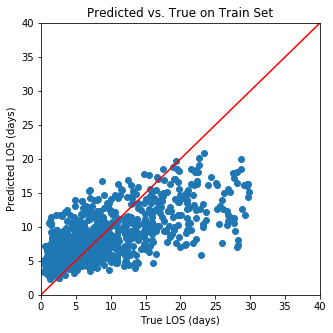

<Figure size 432x288 with 0 Axes>

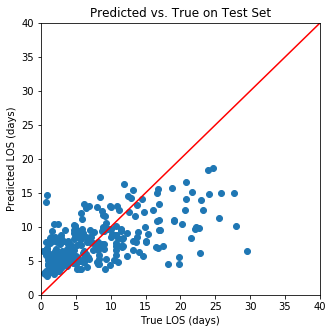

In [319]:
# Plotting predictions against true
xmax = 40
ymax = 40

x = list(range(0,xmax+1))
y = x

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_train, y_train_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Train Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Test Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

In [26]:
for c in data.columns:
    print(c)

gcs0
gcs1
gcs2
gcs3
gcs4
hr0
hr1
hr2
hr3
hr4
resp0
resp1
resp2
resp3
resp4
sao20
sao21
sao22
sao23
sao24
NC_verbal
NC_eyes
NC_temp
LAB_Hct
LAB_Hgb
LAB_WBC x 1000
LAB_glucose
LAB_platelets x 1000
DEM_age
DEM_admissionheight
DEM_admissionweight
DEM_gender
AP_sys
AP_dias
AP_bp
RESP_A1: High Exhaled Vt
RESP_B1: IPAP
RESP_B2: EPAP
RESP_B3: Est Mask Leak
RESP_CPAP
RESP_Compliance
RESP_ETCO2
RESP_Exhaled MV
RESP_Exhaled TV (machine)
RESP_Exhaled TV (patient)
RESP_FiO2
RESP_Flow Sensitivity
RESP_Humidifier Temp
RESP_LPM O2
RESP_Mean Airway Pressure
RESP_PEEP
RESP_PEEP/CPAP
RESP_Peak Flow
RESP_Peak Insp. Pressure
RESP_Plateau Pressure
RESP_Pressure Control
RESP_Pressure Support
RESP_Pressure to Trigger PS
RESP_TV/kg IBW
RESP_Tidal Volume (set)
RESP_Vent Rate
INVASIVE_icp
INVASIVE_pamean
INVASIVE_cvp
INVASIVE_systemicmean
INTAKEOUTPUT_dialysistotal


# Support Vector Regression

In [216]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# select features using threshold
numfeat = 40
# for thresh in [0.05, -np.inf]:

grouped_train_rmses = [0]*n_groups
grouped_test_rmses = [0]*n_groups
train_rmses = []
test_rmses = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2)
#     for thresh in [-np.inf]:
#         selection = SelectFromModel(xg_reg, threshold=thresh, prefit=True, max_features=numfeat)
#         feature_idx = selection.get_support()
#         feature_name = X_train.columns[feature_idx]
# #         print(feature_name)
#         select_X_train = selection.transform(X_train)
        
    X_train_norm = preprocessing.normalize(X_train)

    regr = make_pipeline(SVR(kernel='rbf', C=0.1, epsilon=0.1))
    regr.fit(X_train_norm, y_train)

    # eval model
    X_test_norm = preprocessing.normalize(X_test)
    y_pred = regr.predict(X_test_norm)
    y_train_pred = regr.predict(X_train_norm)

    train_labs = pd.DataFrame(list(zip(y_train_pred, y_train)), columns=['y_pred', 'y_train'])
    for i in range(n_groups):
        df1 = train_labs[train_labs['y_train'] >= groups[i]]
        df1 = df1[df1['y_train'] < groups[i+1]]
        yt = list(df1['y_train'])
        yp = list(df1['y_pred'])
        grouped_train_rmses[i] = grouped_train_rmses[i] + np.sqrt(mean_squared_error(yt, yp))

    test_labs = pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])
    for i in range(n_groups):
        df1 = test_labs[test_labs['y_test'] >= groups[i]]
        df1 = df1[df1['y_test'] < groups[i+1]]
        yt = list(df1['y_test'])
        yp = list(df1['y_pred'])
        grouped_test_rmses[i] = grouped_test_rmses[i] + np.sqrt(mean_squared_error(yt, yp))

    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(train_rmse)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_rmses.append(rmse)
    print("Train RMSE: %f" % (train_rmse))
    print("Test RMSE: %f" % (rmse))

Train RMSE: 6.523493
Test RMSE: 6.493738
Train RMSE: 6.529900
Test RMSE: 6.565825
Train RMSE: 6.480232
Test RMSE: 6.691776
Train RMSE: 6.545300
Test RMSE: 6.599538
Train RMSE: 6.528076
Test RMSE: 6.573362
Train RMSE: 6.572865
Test RMSE: 6.471031
Train RMSE: 6.498924
Test RMSE: 6.527811
Train RMSE: 6.551001
Test RMSE: 6.418639
Train RMSE: 6.478858
Test RMSE: 6.715415
Train RMSE: 6.478920
Test RMSE: 6.652045
Train RMSE: 6.532732
Test RMSE: 6.588179
Train RMSE: 6.523193
Test RMSE: 6.503391
Train RMSE: 6.525726
Test RMSE: 6.510185
Train RMSE: 6.567054
Test RMSE: 6.409671
Train RMSE: 6.554823
Test RMSE: 6.461257
Train RMSE: 6.589443
Test RMSE: 6.331238
Train RMSE: 6.497481
Test RMSE: 6.698548
Train RMSE: 6.505806
Test RMSE: 6.596783
Train RMSE: 6.562986
Test RMSE: 6.595894
Train RMSE: 6.532047
Test RMSE: 6.609393


In [217]:
print(np.mean(train_rmses))
print(np.mean(test_rmses))

print()

print([i/20 for i in grouped_train_rmses])
print([i/20 for i in grouped_test_rmses])

6.528943028367152
6.550685984354208

[2.7865629112084593, 8.594838277371128, 18.37590718161078]
[2.8014512758232892, 8.463790430563353, 18.261290575418737]


Text(0, 0.5, 'Predicted LOS (days)')

<Figure size 432x288 with 0 Axes>

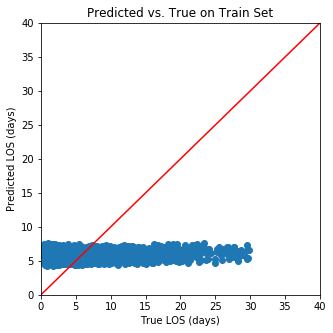

<Figure size 432x288 with 0 Axes>

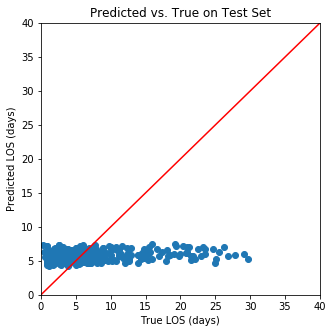

In [72]:
# Plotting predictions against true
xmax = 40
ymax = 40

x = list(range(0,xmax+1))
y = x

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_train, y_train_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Train Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Test Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

# Random Forest Regression

In [218]:
from sklearn.ensemble import RandomForestRegressor

# select features using threshold
numfeat = 40
# for thresh in [0.05, -np.inf]:

train_rmses = []
test_rmses = []
grouped_train_rmses = [0]*n_groups
grouped_test_rmses = [0]*n_groups
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2)
#     for thresh in [-np.inf]:
#         selection = SelectFromModel(xg_reg, threshold=thresh, prefit=True, max_features=numfeat)
#         feature_idx = selection.get_support()
#         feature_name = X_train.columns[feature_idx]
# #         print(feature_name)
#         select_X_train = selection.transform(X_train)
        
    X_train_norm = preprocessing.normalize(X_train)

    rfregr = RandomForestRegressor(n_estimators=200, max_depth=2, random_state=0)
    rfregr.fit(X_train_norm, y_train)

    # eval model
    X_test_norm = preprocessing.normalize(X_test)
    y_pred = rfregr.predict(X_test_norm)
    y_train_pred = rfregr.predict(X_train_norm)
    
    train_labs = pd.DataFrame(list(zip(y_train_pred, y_train)), columns=['y_pred', 'y_train'])
    for i in range(n_groups):
        df1 = train_labs[train_labs['y_train'] >= groups[i]]
        df1 = df1[df1['y_train'] < groups[i+1]]
        yt = list(df1['y_train'])
        yp = list(df1['y_pred'])
        grouped_train_rmses[i] = grouped_train_rmses[i] + np.sqrt(mean_squared_error(yt, yp))

    test_labs = pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])
    for i in range(n_groups):
        df1 = test_labs[test_labs['y_test'] >= groups[i]]
        df1 = df1[df1['y_test'] < groups[i+1]]
        yt = list(df1['y_test'])
        yp = list(df1['y_pred'])
        grouped_test_rmses[i] = grouped_test_rmses[i] + np.sqrt(mean_squared_error(yt, yp))


    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(train_rmse)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_rmses.append(rmse)
    print("Train RMSE: %f" % (train_rmse))
    print("Test RMSE: %f" % (rmse))

Train RMSE: 5.789914
Test RMSE: 5.662650
Train RMSE: 5.705953
Test RMSE: 5.966588
Train RMSE: 5.712981
Test RMSE: 5.883873
Train RMSE: 5.763030
Test RMSE: 5.893376
Train RMSE: 5.724378
Test RMSE: 5.927532
Train RMSE: 5.731669
Test RMSE: 5.817102
Train RMSE: 5.677974
Test RMSE: 6.168711
Train RMSE: 5.693319
Test RMSE: 6.004312
Train RMSE: 5.695535
Test RMSE: 5.956039
Train RMSE: 5.752374
Test RMSE: 5.787579
Train RMSE: 5.693968
Test RMSE: 5.952298
Train RMSE: 5.679879
Test RMSE: 6.021834
Train RMSE: 5.689487
Test RMSE: 6.055744
Train RMSE: 5.783468
Test RMSE: 5.630121
Train RMSE: 5.727892
Test RMSE: 5.764943
Train RMSE: 5.697253
Test RMSE: 5.917882
Train RMSE: 5.703425
Test RMSE: 5.939313
Train RMSE: 5.714336
Test RMSE: 6.101916
Train RMSE: 5.717224
Test RMSE: 5.875636
Train RMSE: 5.716749
Test RMSE: 5.871549


In [220]:
print(np.mean(train_rmses))
print(np.mean(test_rmses))

print()

print([i/20 for i in grouped_train_rmses])
print([i/20 for i in grouped_test_rmses])

5.718540440555879
5.9099499598817475

[3.7208824259661677, 6.090680242307894, 15.002511865834299]
[3.9124146801756225, 6.3761030719927225, 15.43761145225378]


Text(0, 0.5, 'Predicted LOS (days)')

<Figure size 432x288 with 0 Axes>

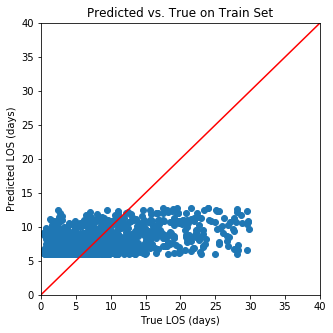

<Figure size 432x288 with 0 Axes>

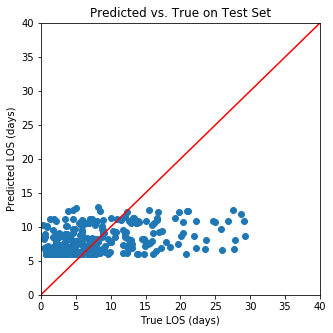

In [221]:
# Plotting predictions against true
xmax = 40
ymax = 40

x = list(range(0,xmax+1))
y = x

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_train, y_train_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Train Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Test Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

# LightGBM

In [252]:
import lightgbm as lgb

# select features using threshold
numfeat = 40
# for thresh in [0.05, -np.inf]:

train_rmses = []
test_rmses = []
grouped_train_rmses = [0]*n_groups
grouped_test_rmses = [0]*n_groups
grouped_train_rmses_onval = [0]*n_groups
grouped_test_rmses_onval = [0]*n_groups
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2)
#     for thresh in [-np.inf]:
#         selection = SelectFromModel(xg_reg, threshold=thresh, prefit=True, max_features=numfeat)
#         feature_idx = selection.get_support()
#         feature_name = X_train.columns[feature_idx]
# #         print(feature_name)
#         select_X_train = selection.transform(X_train)
        
    X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]
    
    X_train_norm = preprocessing.normalize(X_train)

    train_data=lgb.Dataset(X_train_norm,label=y_train)
    params = {'n_iter':200, 'learning_rate':0.01, 'num_leaves':20, 'max_depth':20, 'min_data_in_leaf':50,
              'lambda_l1':0.5, 'objective':'rmse', 'boosting':'gbdt'}
    model= lgb.train(params, train_data, 100)

    # eval model
    X_test_norm = preprocessing.normalize(X_test)
    y_pred = model.predict(X_test_norm)
    y_train_pred = model.predict(X_train_norm)
    
    train_labs = pd.DataFrame(list(zip(y_train_pred, y_train)), columns=['y_pred', 'y_train'])
    for i in range(n_groups):
        df1 = train_labs[train_labs['y_train'] >= groups[i]]
        df1 = df1[df1['y_train'] < groups[i+1]]
        yt = list(df1['y_train'])
        yp = list(df1['y_pred'])
        grouped_train_rmses[i] = grouped_train_rmses[i] + np.sqrt(mean_squared_error(yt, yp))
        
    train_labs = pd.DataFrame(list(zip(y_train_pred, y_train)), columns=['y_pred', 'y_train'])
    for i in range(n_groups):
        df1 = train_labs[train_labs['y_pred'] >= groups[i]]
        df1 = df1[df1['y_pred'] < groups[i+1]]
        yt = list(df1['y_train'])
        yp = list(df1['y_pred'])
        if (df1.shape[0] > 0):
            grouped_train_rmses_onval[i] = grouped_train_rmses_onval[i] + np.sqrt(mean_squared_error(yt, yp))
        else:
            grouped_train_rmses_onval[i] = math.inf

    test_labs = pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])
    for i in range(n_groups):
        df1 = test_labs[test_labs['y_test'] >= groups[i]]
        df1 = df1[df1['y_test'] < groups[i+1]]
        yt = list(df1['y_test'])
        yp = list(df1['y_pred'])
        grouped_test_rmses[i] = grouped_test_rmses[i] + np.sqrt(mean_squared_error(yt, yp))
        
    test_labs = pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])
    for i in range(n_groups):
        df1 = test_labs[test_labs['y_pred'] >= groups[i]]
        df1 = df1[df1['y_pred'] < groups[i+1]]
        yt = list(df1['y_test'])
        yp = list(df1['y_pred'])
        if (df1.shape[0] > 0):
            grouped_test_rmses_onval[i] = grouped_test_rmses_onval[i] + np.sqrt(mean_squared_error(yt, yp))
        else:
            grouped_test_rmses_onval[i] = math.inf


    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmses.append(train_rmse)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_rmses.append(rmse)
    print("Train RMSE: %f" % (train_rmse))
    print("Test RMSE: %f" % (rmse))

C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.993138
Test RMSE: 5.558702


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.894406
Test RMSE: 5.590470


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.661279
Test RMSE: 6.515542


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 5.070668
Test RMSE: 5.615414


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.819349
Test RMSE: 5.893421


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 5.146371
Test RMSE: 5.470783


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 5.030407
Test RMSE: 5.654173


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.910644
Test RMSE: 5.759725


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.857716
Test RMSE: 5.992443


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.951321
Test RMSE: 5.789105


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.901820
Test RMSE: 6.218522


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.920937
Test RMSE: 5.966447


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.949322
Test RMSE: 5.809453


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.980862
Test RMSE: 6.029407


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.867909
Test RMSE: 5.910618


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.806831
Test RMSE: 6.062403


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.942060
Test RMSE: 5.888509


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.812722
Test RMSE: 5.883308


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 4.770673
Test RMSE: 6.366415


C:\Users\owner\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train RMSE: 5.031880
Test RMSE: 5.683099


In [253]:
print(np.mean(train_rmses))
print(np.mean(test_rmses))

print()

print([i/20 for i in grouped_train_rmses])
print([i/20 for i in grouped_test_rmses])

print()

print([i/20 for i in grouped_train_rmses_onval])
print([i/20 for i in grouped_test_rmses_onval])

4.916015770410389
5.882897873316798

[3.1400478258655067, 5.540553713530252, 14.46092038176242]
[3.524565437022192, 6.390498407817312, 16.588933966628485]

[4.791951785630792, inf, inf]
[5.833143358844968, inf, inf]


Text(0, 0.5, 'Predicted LOS (days)')

<Figure size 432x288 with 0 Axes>

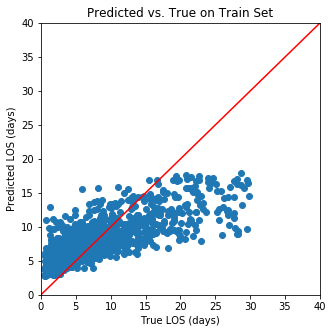

<Figure size 432x288 with 0 Axes>

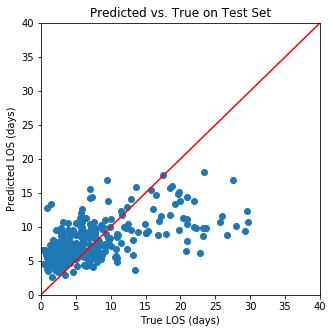

In [241]:
# Plotting predictions against true
xmax = 40
ymax = 40

x = list(range(0,xmax+1))
y = x

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_train, y_train_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Train Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Test Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

In [225]:
print(groups)

[0, 10, 20, 31]
